# First testing of retrieval

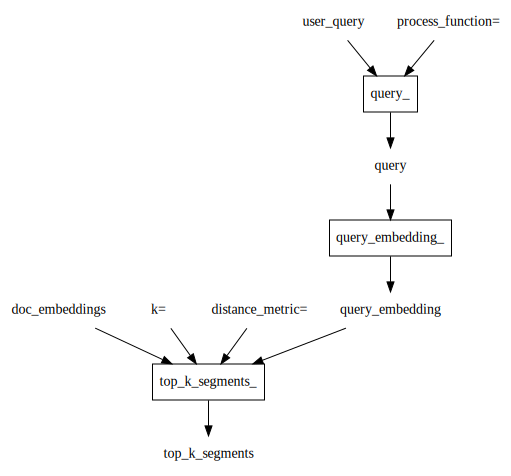

In [1]:
from raglab.retrieval.lib_alexis import dag, generate_split_keys
doc_embeddings = dag[:"doc_embeddings"]
top_k = dag["user_query":"top_k_segments"]
top_k.dot_digraph()

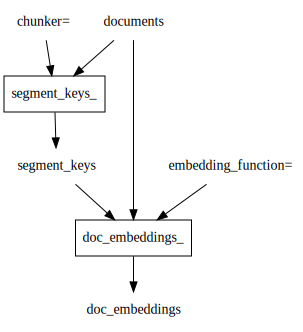

In [2]:
doc_embeddings.dot_digraph()

In [45]:
from dol import Files
f = Files("./data_ad")
d ={key: f[key].decode() for key in f} 

In [51]:
from functools import partial
_generate_split_keys =  partial(generate_split_keys, chunk_overlap=40, chunk_size=300)

In [52]:
doc_embed = doc_embeddings(documents=d, chunker = _generate_split_keys)

In [53]:
from functools import partial
pipeline = partial(top_k, doc_embeddings=doc_embed)

In [54]:
test_set = {
    "Une personne qui habite une ville côtière": "dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre",
    "quel est le passe temps préféré du protagoniste": "Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable",
    "Pierre aperçois un objet lors d'une promenade, quel est il?": "Pierre découvrit une bouteille mystérieuse",
    "Que contenait la bouteille?": "petite carte était enroulée à l'intérieur",
    "Depuis combien de temps le trésor était-il caché?": "un trésor caché depuis des siècles",
    "Pierre pars chercher le trésor": "Pierre décida de partir à l'aventure",
    "Obstacles naturels sur le parcours": "forêt dense, escalada des rochers escarpés et traversa des rivières tumultueuses",
    "Combien de temps dur le trajet": "une longue journée",
    "contenu du trésor est magnigifique": "rempli de pièces d'or étincelantes et de joyaux étincelants",
    "a quels membre de son entourage partage-il la découverte?": "sa famille et à ses amis",
    "Quel est alors la réputation de Pierre dans sa ville": "connu comme le plus grand aventurier de la ville",
}    

In [55]:
score = 0
for query, responce in test_set.items():
    print(f"\n-------------\n Query: {query}")
    print(f"Expected: {responce}")
    res = pipeline(user_query=query, k=1)
    segment_key=res[0]
    if responce in d[segment_key[0]][segment_key[1]:segment_key[2]]:
        score += 1
        print("correct!")
    print(f"Predicted: {d[segment_key[0]][segment_key[1]:segment_key[2]]}")

print(f"\nScore: {score}/{len(test_set)}")



-------------
 Query: Une personne qui habite une ville côtière
Expected: dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre
correct!
Predicted: Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable.

-------------
 Query: quel est le passe temps préféré du protagoniste
Expected: Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à construire des châteaux de sable
Predicted: Il rentra chez lui en courant pour montrer son trésor à sa famille et à ses amis. À partir de ce jour-là, Pierre fut connu comme le plus grand aventurier de la ville, et chaque fois qu'il retournait à la plage, il se souvenait de l'excitation de sa grande aventure à la recherche du trésor caché.

-------------
 Query: Pierre aperçois un objet lors d'une promenade, quel est

# visualize embeddings

In [39]:
# dump .tsv file to save vectors
vectors = list(doc_embed.values()) + dag["user_query":"query_embedding"](user_query="Une personne qui habite une ville côtière")
labels = list(doc_embed.keys()) + ["Une personne qui habite une ville côtière"]


In [34]:
"a \n".replace("\n", "")

'a '

In [44]:
# visualisation of embaddings with labels
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(list(doc_embed.values()))
sentences = [d[key[0]][key[1]:key[2]] for key in doc_embed.keys()]
print(len(principalComponents), len(sentences))
sentence_embd = zip(sentences, principalComponents)
with open("embeddings_story.tsv", "w") as f:
    with open("embeddings_metadata_story.tsv", "w") as fm:
        for k, v in sentence_embd :
            fm.write(k.replace("\n", "") + "\n")
            f.write("\t".join([str(x).replace("\n", "") for x in v]) + "\n")
            print(v,k)


25 25
[ 0.263606   -0.16116216  0.24300912] Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à chercher des coquillages brillants et à
[ 0.15252536 -0.03040171 -0.14722567] chercher des coquillages brillants et à construire des châteaux de sable.
[ 0.32028301 -0.09492968  0.2574581 ] Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa
[ 0.21093002  0.05010822 -0.19036478] pour voir ce qu'elle contenait. À sa grande surprise, une petite carte était enroulée à l'intérieur.
[ 0.2480553   0.02308763 -0.13970906] La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à l'aventure pour trouver le trésor.
[0.31339917 0.07151561 0.13113321] Il marcha à trave

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.00505012 -0.01125633  0.02729863 ... -0.01323909 -0.01103879
 -0.01737863].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [9]:
for k in doc_embed:
    print(d[k[0]][k[1]:k[2]])
    print("\n")

Il était une fois dans une petite ville au bord de la mer, vivait un jeune garçon nommé Pierre.


vivait un jeune garçon nommé Pierre. Pierre aimait passer ses journées à explorer les plages, à


ses journées à explorer les plages, à chercher des coquillages brillants et à construire des


brillants et à construire des châteaux de sable.


Un jour, alors qu'il se promenait sur la plage, Pierre découvrit une bouteille mystérieuse échouée


une bouteille mystérieuse échouée sur le sable. Il la ramassa avec curiosité et la déboucha pour


avec curiosité et la déboucha pour voir ce qu'elle contenait. À sa grande surprise, une petite


À sa grande surprise, une petite carte était enroulée à l'intérieur.


La carte indiquait un endroit secret sur l'île où se trouvait un trésor caché depuis des siècles.


un trésor caché depuis des siècles. Excité par cette découverte, Pierre décida de partir à


découverte, Pierre décida de partir à l'aventure pour trouver le trésor.


Il marcha à travers la